# Alunos
* Arthur Severo
* Victor Le Roy

#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

9482    3
6009    4
178     2
6894    3
5985    3
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

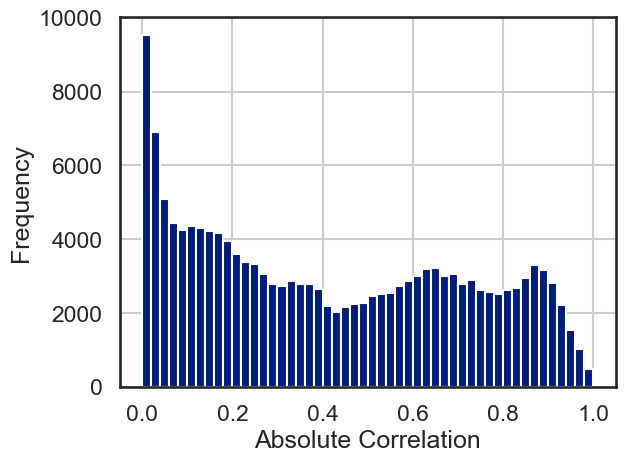

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty=None).fit(X_train, y_train)
lr.coef_

array([[ -74.99258775,   11.56119732,   16.53422018, ...,  849.32406958,
        -345.72919745, -129.19100975],
       [-251.27219349,  -98.42601793,   18.6513434 , ..., -113.83250652,
        -100.52853381,  -63.56480618],
       [ 109.53041248,   80.52822678,   92.62851002, ..., -325.53780435,
         229.19630286,   26.277458  ],
       [  14.25886185,  -18.50007734,    1.62222455, ..., -153.38161852,
          29.66262118,   85.00954482],
       [ 142.11830765,   30.35151423,    3.29850035, ..., -278.52022022,
         -14.27120958,   -7.80215534],
       [  60.35719927,   -5.51484307, -132.73479851, ...,   21.94808003,
         201.6700168 ,   89.27096845]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l1.coef_

array([[-0.01342249,  0.        ,  0.        , ...,  5.0644181 ,
        -2.12766458,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -8.14444756,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.2724284 ,  0.        ,  0.        , ..., -0.78602501,
         0.        ,  0.        ],
       [-0.80651555, -9.72858031, -2.73158945, ...,  0.33577832,
         2.82076525,  3.3254143 ]])

In [18]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)
lr_l2.coef_

array([[-8.51362712e-02,  3.81904426e-02,  3.63766397e-02, ...,
         1.93173856e+00, -1.00084016e+00, -2.54733522e-01],
       [-5.47656008e-01, -2.18015756e-01, -2.76046831e-02, ...,
        -8.94933949e-01, -6.54948644e-01, -2.00533743e-01],
       [ 3.88615919e-01,  1.32824131e-01,  2.24556830e-01, ...,
        -9.75978469e-01,  1.60693329e+00,  3.72649730e-01],
       [-3.51487374e-02, -1.99400686e-02,  6.90853119e-03, ...,
        -1.94339541e-01, -1.15641003e-01,  7.69356014e-02],
       [ 3.65056568e-01,  1.26200902e-01, -1.56405229e-03, ...,
        -4.43430391e-01, -2.67821485e-01, -2.15196599e-01],
       [-8.57314704e-02, -5.92596500e-02, -2.38673266e-01, ...,
         5.76943791e-01,  4.32318002e-01,  2.20878534e-01]])

In [19]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
lr_newton = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', max_iter=10000).fit(X_train, y_train)

In [20]:
lr_lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', max_iter=10000).fit(X_train, y_train)

In [21]:
lr_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag', max_iter=10000).fit(X_train, y_train)

In [22]:
lr_saga_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', max_iter=10000).fit(X_train, y_train)

In [ ]:
lr_saga_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', max_iter=10000).fit(X_train, y_train)

Analise:
* Foi possível utilizar a penalidade L1 apenas em "liblinear" e "saga", enquanto o L2 foi utilizado em "newton-cg", "lbfgs" e "sag"
* O tempo de execução dos métodos que utilizaram o L1

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [ ]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                              \
             0           1           2           3           4           5   
17   21.118721    7.452888   63.676784   -9.720704  -59.934393  -22.593297   
284 -99.323753  -82.296713 -111.762760   18.906814  156.352990  118.123423   
353 -87.066171  -80.415033  -56.422569  169.734482   23.533883   30.635407   
424 -64.738909 -136.824808   19.062554   85.025245   79.335956   18.139962   
312  10.259393   11.845558   53.673007 -104.487633   55.227780  -26.518105   
178   7.714569    5.245065   74.073028  -59.299092   -9.632082  -18.101486   
538  21.451613 -262.947884  135.125536  127.227349   38.528704  -59.385319   
34  -25.253824 -123.258461   11.312915   49.919052  117.471639  -30.191321   
122  56.213456  -74.649224   64.759442 -126.494343    9.176103   70.994566   
187  -3.284883  427.145735 -413.749319  -58.580122  -34.375121   82.843710   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
17  -0.072542  0.000000  0.684065  0.000000  0.256534  0.937560 -0.009176   
284 -0.009193  0.000000  0.000000  0.000000  1.849001  0.641963 -0.054643   
353 -0.006867  0.000000  0.000000  0.027550 -0.700148 -1.611741 -0.049468   
424 -0.001151  0.000000  0.000000  0.000000 -0.393185 -0.413930 -0.008116   
312 -0.004566  0.000000  0.000000  0.000000  1.863433  0.041782 -0.010560   
178 -0.006969  0.000000  0.007675  0.000000  0.131346  0.017412 -0.018547   
538  0.118817 -0.118728  0.000000  0.660659 -0.313801 -4.381789  0.154940   
34   0.000000  0.000000  0.000000  0.000000  1.357962 -0.727075 -0.070541   
122  1.434420 -2.699407  0.000000  0.000000 -1.393390  1.646949  0.149161   
187  0.000000  4.985339 -4.624903  0.000000 -3.343504  2.361543  0.032990   

                                                       
            1         2         3         4         5  
17  -0.045901  0.036464  0.056317 -0.025552 -0.012152  
284 -0.081659 -0.134247 -0.197157  0.323354  0.144351  
353 -0.119464 -0.077210  0.386586 -0.043997 -0.096446  
424 -0.255225  0.103925  0.131985  0.048885 -0.021454  
312 -0.055096  0.016835 -0.190232  0.236658  0.002395  
178 -0.066104  0.054778 -0.003680  0.084565 -0.051012  
538 -0.279851  0.126324  0.366423  0.058124 -0.425961  
34  -0.333263  0.339269  0.037788  0.176512 -0.149765  
122 -0.281932  0.162285 -0.348977  0.041316  0.278146  
187  1.654150 -1.602828 -0.183435 -0.197920  0.297044

Analise visualizada pela tabela:
* cada LR recebeu 6 coeficientes, em que cada um dos coeficientes representam um dos atributos encodados de 0 - 5
* Cada linha representa as features
* Os exemplos na regressão linear demonstram muita variância devido a não penalidade das features, uma vez que ele apenas adiciona ou remove as mesmas
* O L1 obteve vários resultados com valor nulo, além de baixa variância
* O L2 também obteve baixa variação em seus resultados

Prepare six separate plots for each of the multi-class coefficients.

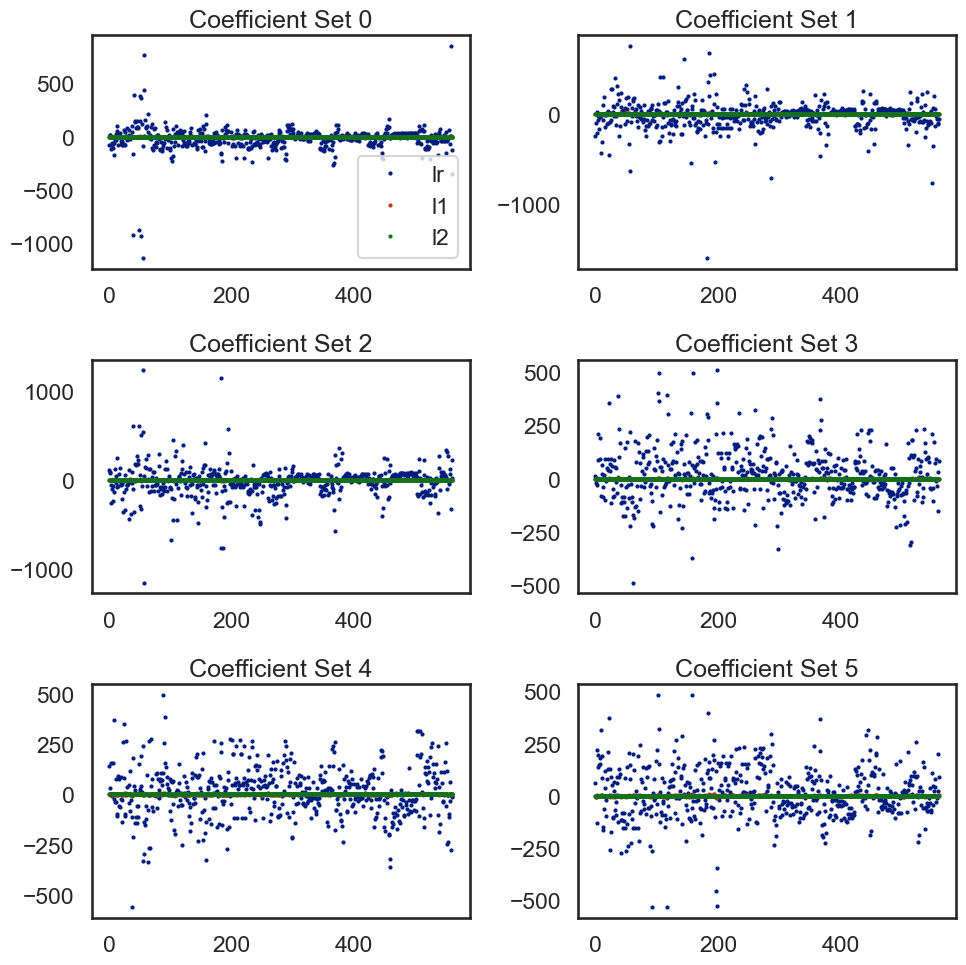

In [ ]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
         
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




Analise do grafico:
* Percebe-se que LR está variando bastante
* L1 e L2 tiveram baixa variação
* L2 houve uma variação inferior à L1

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [ ]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [ ]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998996,0.999998
1,1.0,0.999722,0.999654
2,1.0,0.996056,0.998873
3,1.0,0.999215,0.997829
4,1.0,0.999919,0.999307


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [ ]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.981546,0.983514,0.983485
recall,0.981553,0.983495,0.983495
fscore,0.981546,0.983492,0.983488
accuracy,0.981553,0.983495,0.983495
auc,0.988812,0.989949,0.989983


Analise:
* Todos os resultados ficaram muito próximos e próximos 1
* Precision: L2 foi o maior
* Recall: L1 e L2 foram identicos e foram os melhores
* Fscore: L1 foi o vencendor entre os três
* Accuracy: L1 e L2 foram identicos e foram os melhores
* AUC: L2 foi o vencedor


## Question 8

Display or plot the confusion matrix for each model.

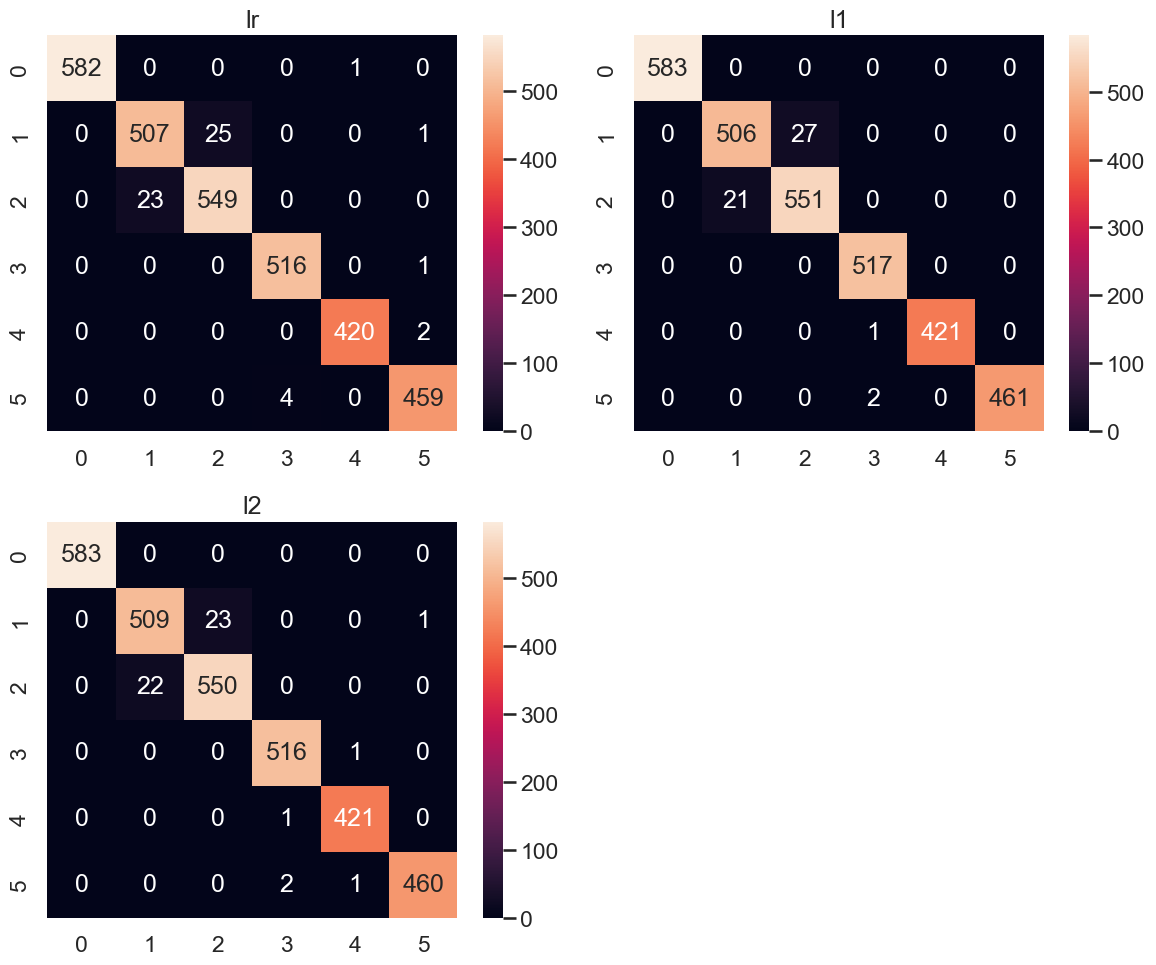

In [ ]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


Analise:
* Todos os métodos obtiveram excelentes resultados para todas as features
* L2 foi o que menos errou para a feature 1 e para a feature 2, o L1 foi o melhor --> Essas foram as features observadas, pois foram as que obtiveram a maior taxa de erro ao comparado com as outras

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(7209, 561)
(7209, 50)
(3090, 561)


 Repeat Model building with new training data after removing higly correlated columns

In [ ]:
# Try standard, L1 and L2 Logistic regression
lr = LogisticRegression(max_iter=10000, penalty=None).fit(X_train_new, y_train_new)

lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train_new, y_train_new)

lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
lr_newton = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', max_iter=10000).fit(X_train_new, y_train_new)

lr_lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', max_iter=10000).fit(X_train, y_train)

lr_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag', max_iter=10000).fit(X_train, y_train)

lr_saga_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', max_iter=10000).fit(X_train, y_train)

lr_saga_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', max_iter=10000).fit(X_train, y_train)

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [ ]:
# Combine all the coefficients into a dataframe
coefficients_new = list()
for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_new.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients_new = pd.concat(coefficients_new, axis=1)

coefficients_new.sample(10)

Prepare six separate plots for each of the multi-class coefficients.

In [ ]:
# try the plots
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
         
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [ ]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [ ]:
# Calculate the error metrics as listed above
metrics_new = list()
cm_new = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm_new[lab] = confusion_matrix(y_test_new, y_pred[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_new = pd.concat(metrics, axis=1)


In [ ]:
#Run the metrics
metrics_new

## Question 13

Display or plot the confusion matrix for each model.

In [ ]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab)
    
plt.tight_layout()

In [ ]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [ ]:
metrics_new - metrics

In [ ]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

In [ ]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm_new[lab] - cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab)
    
plt.tight_layout()